In [24]:
import os
os.chdir('/home/jennifer.badolato/watttime-python-client-aer-algo')

import numpy as np
import pandas as pd
import datetime
import random
import pytz
from datetime import datetime, timedelta
import random
from watttime import WattTimeHistorical, WattTimeForecast
import os
import optimizer.dataset as od
from evaluation.config import MOER_REGION_LIST
import evaluation.eval_framework as evu
import optimizer.s3 as s3u

import seaborn as sns
import matplotlib.pyplot as plt

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

In [4]:
start = "2024-02-01"
end = "2024-02-15"

distinct_date_list = [
    pd.Timestamp(date)
    for date in pd.date_range(start, end, freq="d").values
]

In [5]:
dfs = evu.execute_synth_data_process(distinct_date_list, number_of_users=1000)

100%|██████████| 1000/1000 [00:11<00:00, 89.01it/s]


In [6]:
s3 = s3u.s3_utils()
key = '20240712_1k_synth_users.csv'
s3.store_csvdataframe(dataframe=dfs, file=key)

Successful S3 put_object response. Status - 200


## Distributions

In [7]:
dfs.uncharged.value_counts()

uncharged
False    12231
True      2769
Name: count, dtype: int64

In [14]:
dfs["length_plugged_in"].describe()

count    15000.000000
mean     25070.243276
std       7949.560606
min      -6481.174485
25%      19731.582106
50%      25082.742579
75%      30471.185898
max      55939.163984
Name: length_plugged_in, dtype: float64

In [18]:
(dfs["length_plugged_in"] < 0).value_counts()

length_plugged_in
False    14984
True        16
Name: count, dtype: int64

Text(0.5, 1.0, 'length_plugged_in')

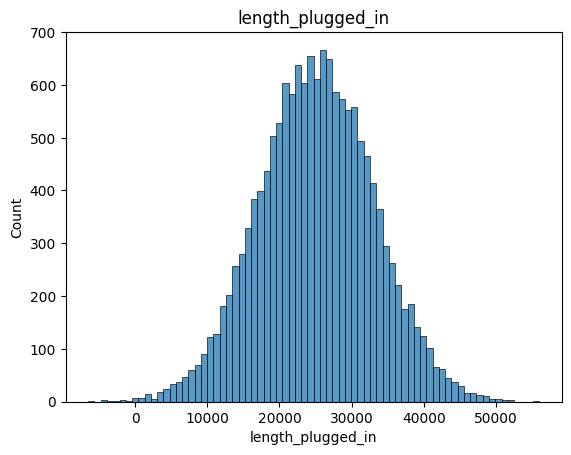

In [8]:
sns.histplot(dfs["length_plugged_in"]).set_title("length_plugged_in")

In [15]:
dfs["total_seconds_to_95"].describe()

count    15000.000000
mean     19354.511756
std      13019.894681
min       1458.650348
25%       9371.594727
50%      15872.801304
75%      26470.543347
max      80761.702311
Name: total_seconds_to_95, dtype: float64

Text(0.5, 1.0, 'total_seconds_to_95')

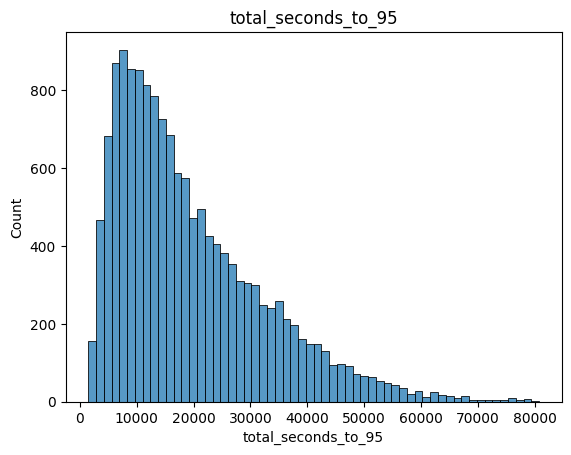

In [9]:
sns.histplot(dfs["total_seconds_to_95"]).set_title("total_seconds_to_95")

Text(0.5, 1.0, 'final_perc_charged')

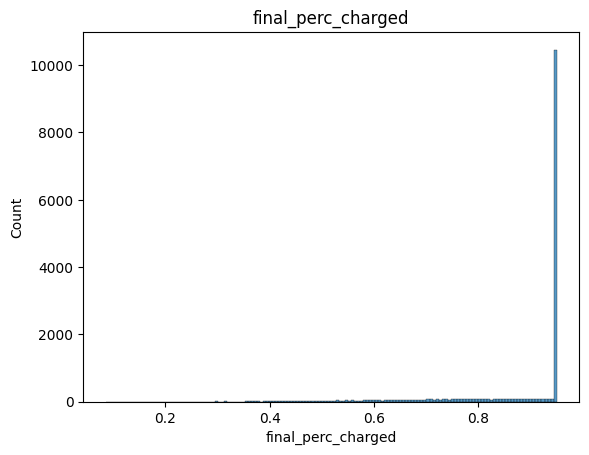

In [10]:
sns.histplot(dfs["final_perc_charged"]).set_title("final_perc_charged")

Text(0.5, 1.0, 'total_capacity')

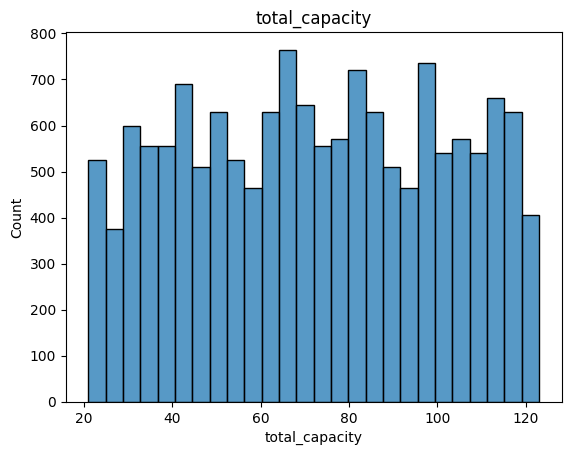

In [11]:
sns.histplot(dfs["total_capacity"]).set_title("total_capacity")

Text(0.5, 1.0, 'charged_kWh_actual')

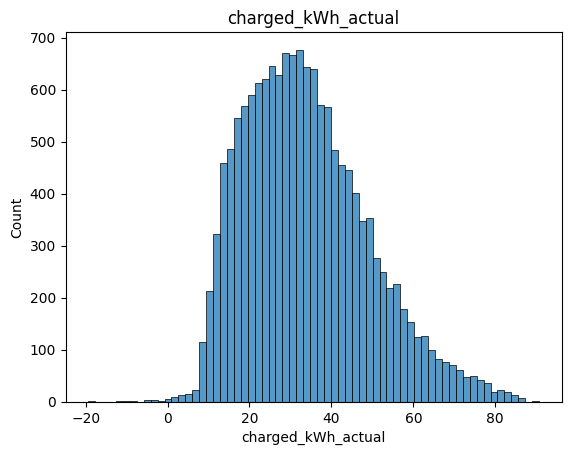

In [12]:
sns.histplot(dfs["charged_kWh_actual"]).set_title("charged_kWh_actual")

Text(0.5, 1.0, 'power_output_rate')

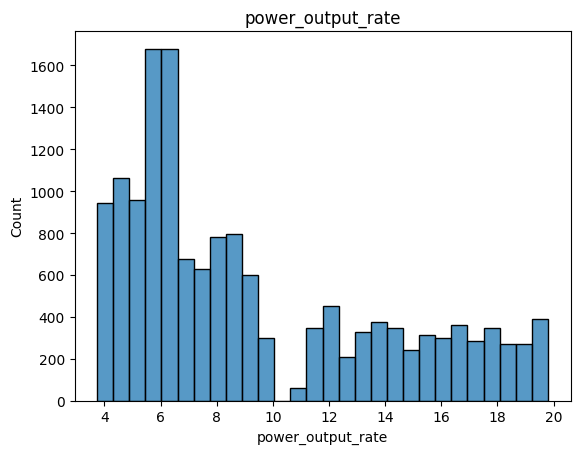

In [21]:
sns.histplot(dfs["power_output_rate"]).set_title("power_output_rate")

- DONE: plug + unplug needs to be specified in a local time + converted to UTC

# Calculate MOERs with no optimization

In [15]:
import os
os.chdir('/home/jennifer.badolato/watttime-python-client-aer-algo')
from watttime.shared_anniez.alg.optCharger import OptCharger, Moer
from watttime import WattTimeHistorical, WattTimeForecast
import pandas as pd
import optimizer.s3 as s3u
import pytz
import evaluation.eval_framework as evu
import seaborn as sns 
import matplotlib.pyplot as plt

In [6]:
# Example timezone as a stand in
[i for i in pytz.all_timezones if 'Eastern' in i]

['Canada/Eastern', 'US/Eastern']

In [7]:
region = "PJM_NJ"
time_zone = 'US/Eastern'
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)

In [8]:
s3 = s3u.s3_utils()
key = '20240712_1k_synth_users.csv'
generated_data = s3.load_csvdataframe(file=key)

In [9]:
def intervalize_power_rate(kW_value: float, convert_to_MW = True):
    five_min_rate = kW_value / 12
    if convert_to_MW:
        five_min_rate = five_min_rate / 1000
    else:
        five_min_rate
    return five_min_rate

In [10]:
moer_actuals = actual_data.get_historical_pandas(
    start=generated_data.plug_in_time.min(),
    end=generated_data.unplug_time.max(),
    region=region
)

In [11]:
generated_data["plug_in_time"] = pd.to_datetime(generated_data["plug_in_time"])
generated_data["MWh_fraction"] = generated_data["power_output_rate"].apply(intervalize_power_rate)
generated_data["number_intervals_drawing_power"] = generated_data.charged_kWh_actual / generated_data.power_output_rate * 60 / 5

In [16]:
def sum_moer_actuals(
    moer_data,
    time_zone,
    MWh_fraction,
    plug_in_time,
    number_conseq_intervals
    ):
    plug_in_time_utc=evu.convert_to_utc(plug_in_time, time_zone)
    index_lower_limit = moer_data[moer_data.point_time >= plug_in_time_utc].index[0]
    index_upper_limit = index_lower_limit + int(number_conseq_intervals)
    return sum(moer_data[index_lower_limit: index_upper_limit]["value"] * MWh_fraction)

In [19]:
generated_data["moer_actuals"] = generated_data.apply(
    lambda x: sum_moer_actuals(
        moer_actuals,
        time_zone,
        x.MWh_fraction,
        x.plug_in_time,
        x.number_intervals_drawing_power
        ),
        axis=1
        )

Text(0.5, 1.0, 'MOER Actuals in lbs of CO2')

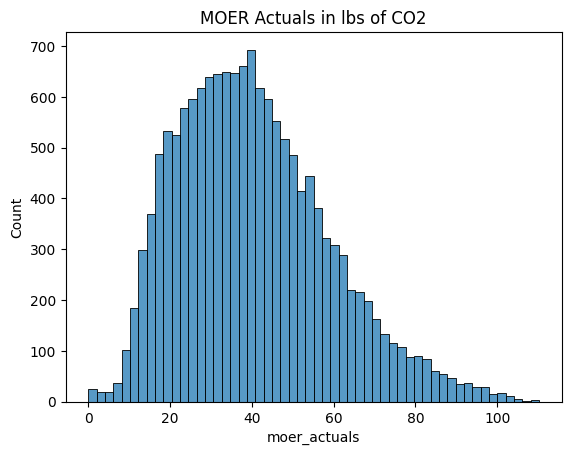

In [22]:
sns.histplot(generated_data["moer_actuals"]).set_title("MOER Actuals in lbs of CO2")